# A Simple Demo of AdaSTEM model using stemflow package

Yangkang Chen<br>
Sep 12, 2023

In [1]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas

# warnings.filterwarnings('ignore')
%matplotlib inline

/Users/chenyangkang/miniforge3/envs/stemflow_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# Download data

In [3]:
# Please download the sample data from:
# https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745
# Now it'd downloaded and saved as './Sample_data_Mallard.csv'

# you can also try other species like 
# https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751
# https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742
# https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748


In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


# Get X and y

In [5]:
X = data.drop('count', axis=1)
y = data['count'].values


# First thing first: Spatio-temporal train test split

In [6]:
from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                       Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                       random_state=42, test_size=0.3)


# Train AdaSTEM hurdle model

In [7]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


In [8]:
model = Hurdle_for_AdaSTEM(
    classifier=AdaSTEMClassifier(base_model=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True,
                                njobs=4),
    regressor=AdaSTEMRegressor(base_model=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True,
                                njobs=4)
)





In [9]:
# columns of X_train should only contain predictors and Spatio-temporal indicators (Spatio1, Spatio2, Temporal1)
model.fit(X_train.reset_index(drop=True), y_train)


100%|██████████| 14959/14959 [03:03<00:00, 81.34it/s]  


# Feature importances

In [10]:
# Calcualte feature importance. This method is automatically called when fitting the model.
# However, to show the process, we call it again.
model.classifier.calculate_feature_importances()
# stixel-specific feature importance is saved in model.classifier.feature_importances_

In [11]:
# Assign the feature importance to spatio-temporal points of interest
importances_by_points = model.classifier.assign_feature_importances_by_points(verbosity=1, njobs=4)


100%|██████████| 10/10 [05:52<00:00, 35.24s/it]


In [12]:
importances_by_points.head()

DOY  longitude  latitude  DOY_predictor  duration_minutes  Traveling  \
781600   64        167       -50       0.019541          0.064949   0.013150   
781601   71        167       -50       0.020026          0.072218   0.015921   
781602   78        167       -50       0.020006          0.076320   0.018692   
781603   85        167       -50       0.021348          0.089307   0.013886   
781604   92        167       -50       0.031823          0.097370   0.011115   

        Stationary  Area  effort_distance_km  number_observers  \
781600    0.003161   0.0            0.039215          0.013081   
781601    0.001581   0.0            0.039459          0.020512   
781602    0.001581   0.0            0.040438          0.023685   
781603    0.000000   0.0            0.035249          0.027943   
781604    0.000000   0.0            0.036249          0.024161   

        obsvr_species_count  time_observation_started_minute_of_day  \
781600             0.025079                                0.038829   
781601             0.024899                                0.047398   
781602             0.025376                                0.051918   
781603             0.018323                                0.054897   
781604             0.015530                                0.053236   

        elevation_mean  slope_mean  eastness_mean  northness_mean      bio1  \
781600        0.040320    0.030780       0.025673        0.098969  0.048968   
781601        0.038270    0.036005       0.025715        0.104146  0.043525   
781602        0.038848    0.036850       0.024455        0.107858  0.045081   
781603        0.038144    0.042700       0.028357        0.090029  0.032588   
781604        0.041549    0.030341       0.028945        0.090243  0.037839   

            bio2      bio3      bio4      bio5      bio6      bio7      bio8  \
781600  0.074037  0.073794  0.014693  0.030967  0.028764  0.003289  0.027758   
781601  0.066875  0.064506  0.010012  0.027194  0.038062  0.002403  0.029307   
781602  0.061568  0.056079  0.003570  0.024242  0.037267  0.002403  0.031589   
781603  0.051164  0.052120  0.018763  0.040573  0.054222  0.001008  0.025215   
781604  0.039839  0.049876  0.017721  0.045627  0.063475  0.001008  0.028909   

            bio9     bio10     bio11     bio12     bio13     bio14     bio15  \
781600  0.020780  0.000954  0.010902  0.022620  0.056649  0.024495  0.011834   
781601  0.018659  0.000570  0.008807  0.020788  0.038936  0.016953  0.024419   
781602  0.018856  0.000185  0.008807  0.020280  0.037864  0.016953  0.029940   
781603  0.023573  0.000243  0.006584  0.012502  0.014576  0.007856  0.045761   
781604  0.022559  0.000273  0.006584  0.011130  0.008976  0.007529  0.034129   

           bio16     bio17     bio18     bio19  \
781600  0.001249  0.015370  0.019347  0.005344   
781601  0.000685  0.010630  0.017919  0.003351   
781602  0.000262  0.005986  0.017296  0.003351   
781603  0.000081  0.005228  0.014155  0.000978   
781604  0.000148  0.005228  0.011686  0.000219   

        cropland_or_natural_vegetation_mosaics  croplands  \
781600                                     0.0        0.0   
781601                                     0.0        0.0   
781602                                     0.0        0.0   
781603                                     0.0        0.0   
781604                                     0.0        0.0   

        deciduous_broadleaf_forests  evergreen_broadleaf_forests  \
781600                          0.0                     0.002279   
781601                          0.0                     0.002790   
781602                          0.0                     0.002790   
781603                          0.0                     0.003667   
781604                          0.0                     0.003740   

        evergreen_needleleaf_forests  grasslands  mixed_forests  \
781600                      0.002405    0.016511       0.001151   
781601                      0.003091    0.016663       

In [13]:
# top 10 important variables
top_10_important_vars = importances_by_points[[
    i for i in importances_by_points.columns if not i in ['DOY','longitude','latitude','longitude_new','latitude_new']
    ]].mean().sort_values(ascending=False).head(10)

print(top_10_important_vars)


slope_mean            0.039851
duration_minutes      0.038208
effort_distance_km    0.037798
elevation_mean        0.036740
bio2                  0.033149
eastness_mean         0.031868
bio3                  0.030921
bio4                  0.030420
bio1                  0.029771
northness_mean        0.028980
dtype: float64


## Ploting the feature importances by vairable names

In [14]:
from stemflow.utils.plot_gif import make_sample_gif

# make spatio-temporal GIF for top 3 variables
for var_ in top_10_important_vars.index[:3]:
    make_sample_gif(importances_by_points, f'./FTR_IPT_{var_}.gif',
                                col=var_, log_scale = False,
                                Spatio1='longitude', Spatio2='latitude', Temporal1='DOY',
                                figsize=(18,9), xlims=(-180, 180), ylims=(-90,90), grid=True,
                                xtick_interval=20, ytick_interval=20,
                                lng_size = 360, lat_size = 180, dpi=100, fps=10)


0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!


![GIF of feature importance for vairable `slope_mean`](../FTR_IPT_slope_mean.gif)

## Plot uncertainty (error) in training 

In [15]:
# calculate mean and standard deviation in occurence estiamtion (classifier)
pred_mean, pred_std = model.classifier.predict(X_train.reset_index(drop=True), 
                                               return_std=True, verbosity=1, njobs=1)



predicting ensemble 9 : 100%|██████████| 4419/4419 [00:06<00:00, 694.48it/s]


In [16]:
# Aggregate error to hexagon
error_df = X_train[['longitude', 'latitude']]
error_df.columns = ['lng', 'lat']
error_df['pred_std'] = pred_std

H_level = 3
error_df = error_df.h3.geo_to_h3(H_level)
error_df = error_df.reset_index(drop=False).groupby(f'h3_0{H_level}').mean()
error_df = error_df.h3.h3_to_geo_boundary()



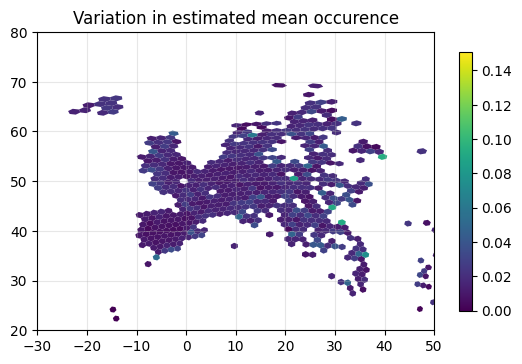

In [17]:
# plot mean error in hexagon
error_df.plot('pred_std', legend=True, legend_kwds={'shrink':0.7})
plt.grid(alpha=0.3)

plt.xlim(-30, 50)
plt.ylim(20, 80)
plt.title('Variation in estimated mean occurence')
plt.show()

# Save model

In [18]:
with open('./01.demo_adastem_model.pkl','wb') as f:
    pickle.dump(model, f)
    

# Evaluation

In [19]:
pred = model.predict(X_test)


predicting ensemble 9 : 100%|██████████| 1578/1578 [00:01<00:00, 1313.22it/s]


In [20]:
perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
print(f'Percentage not predictable {round(perc*100, 2)}%')

Percentage not predictable 5.32%


In [21]:
pred_df = pd.DataFrame({
    'y_true':y_test.flatten(),
    'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
}).dropna()


In [22]:
AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)


{'AUC': 0.6837399894599123,
 'kappa': 0.4186078272738738,
 'f1': 0.4983167142261694,
 'precision': 0.608011892653157,
 'recall': 0.4221534115601912,
 'average_precision': 0.35333650861455296,
 'Spearman_r': 0.4383289790296853,
 'Pearson_r': 0.19693116275354403,
 'R2': -0.03283957740175758,
 'MAE': 4.068249077078515,
 'MSE': 1219.066475781944,
 'poisson_deviance_explained': 0.15655852610155674}

# Compared to simple Hurdle model

In [23]:
model2 = Hurdle(classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1))
model2.fit(X_train[[i for i in X_train.columns if not i in ['longitude','latitude']]], y_train)
pred2 = model2.predict(X_test[[i for i in X_train.columns if not i in ['longitude','latitude']]])

AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), np.where(pred2.flatten()<0, 0, pred2.flatten()))

{'AUC': 0.616011174064,
 'kappa': 0.30474668259547266,
 'f1': 0.3708082385307458,
 'precision': 0.6425718335266074,
 'recall': 0.26059465956001465,
 'average_precision': 0.28919844789235066,
 'Spearman_r': 0.35323288824293075,
 'Pearson_r': 0.10851388312846838,
 'R2': -0.09719472431634424,
 'MAE': 3.997045368413393,
 'MSE': 1378.6207403407598,
 'poisson_deviance_explained': 0.04734125147883528}

# Plot QuadTree ensembles

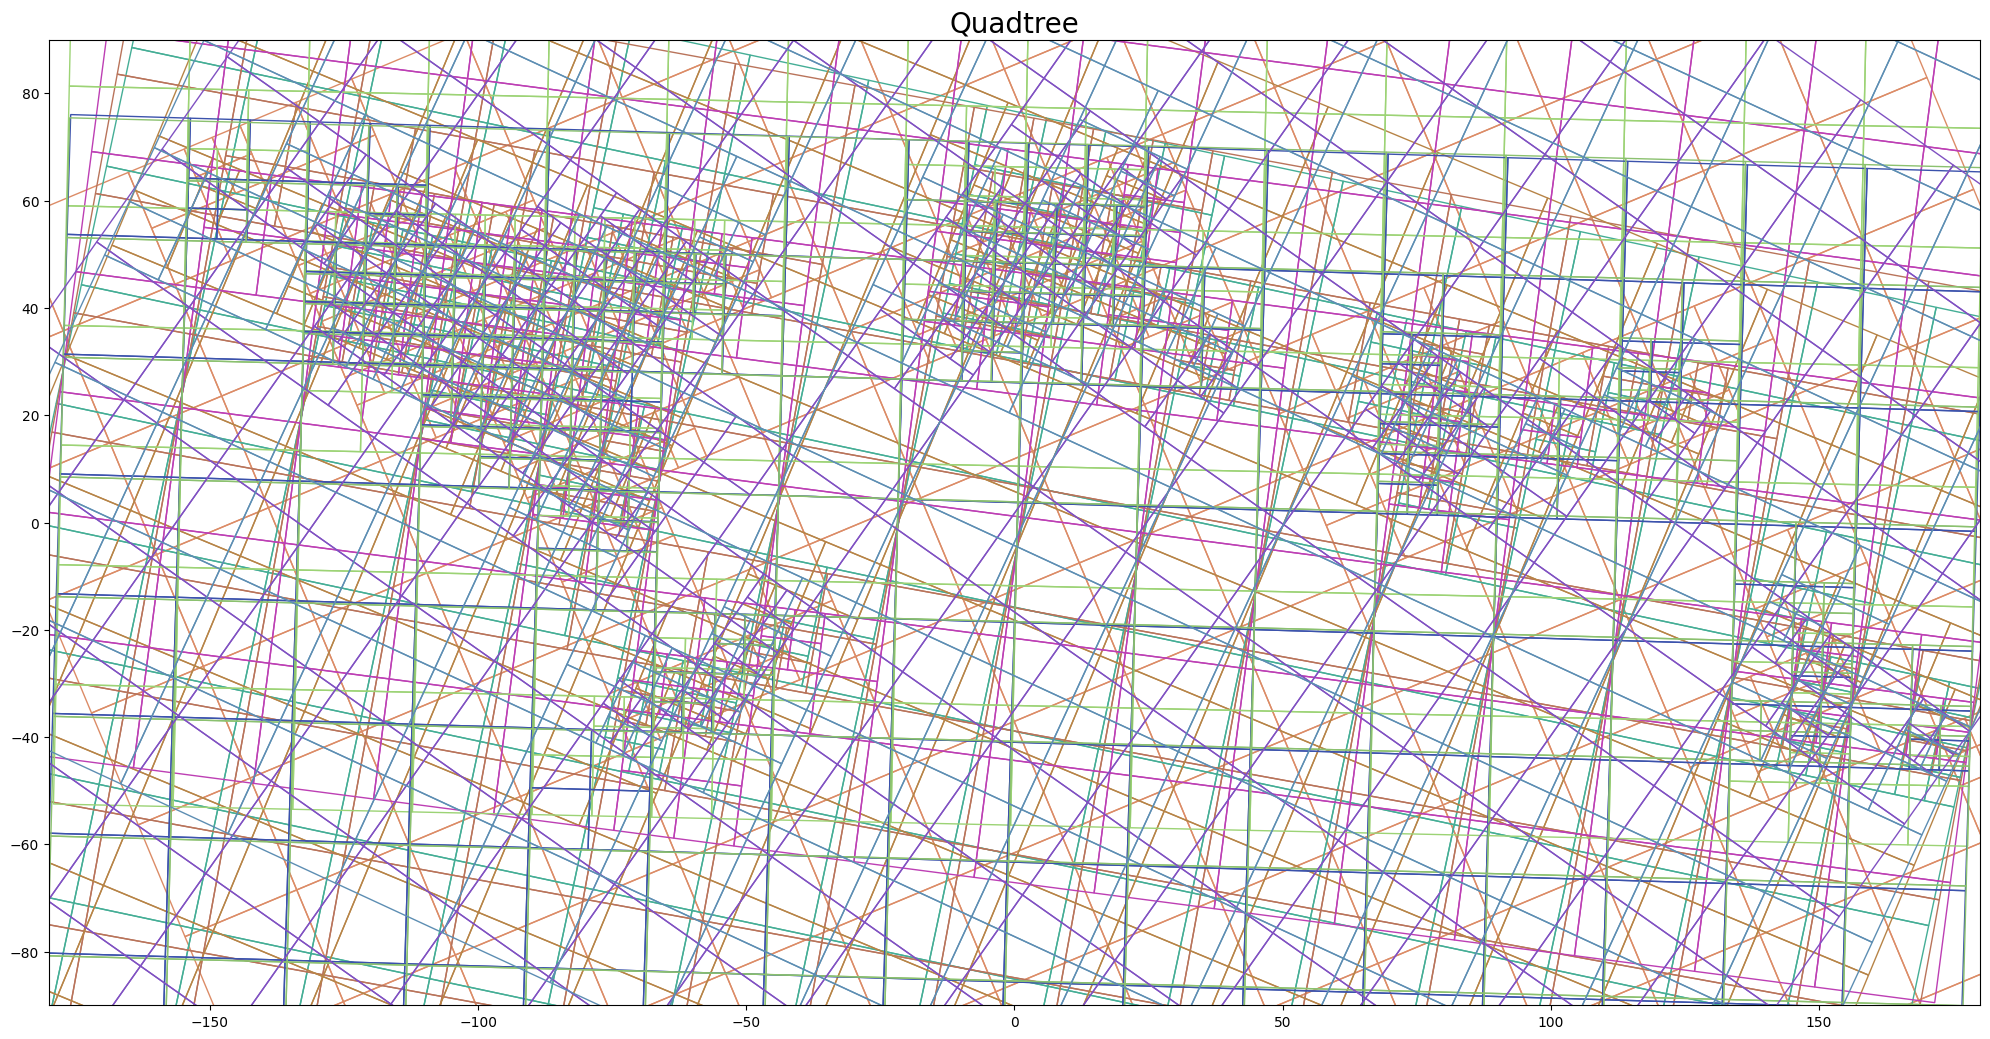

In [24]:
model.classifier.gridding_plot

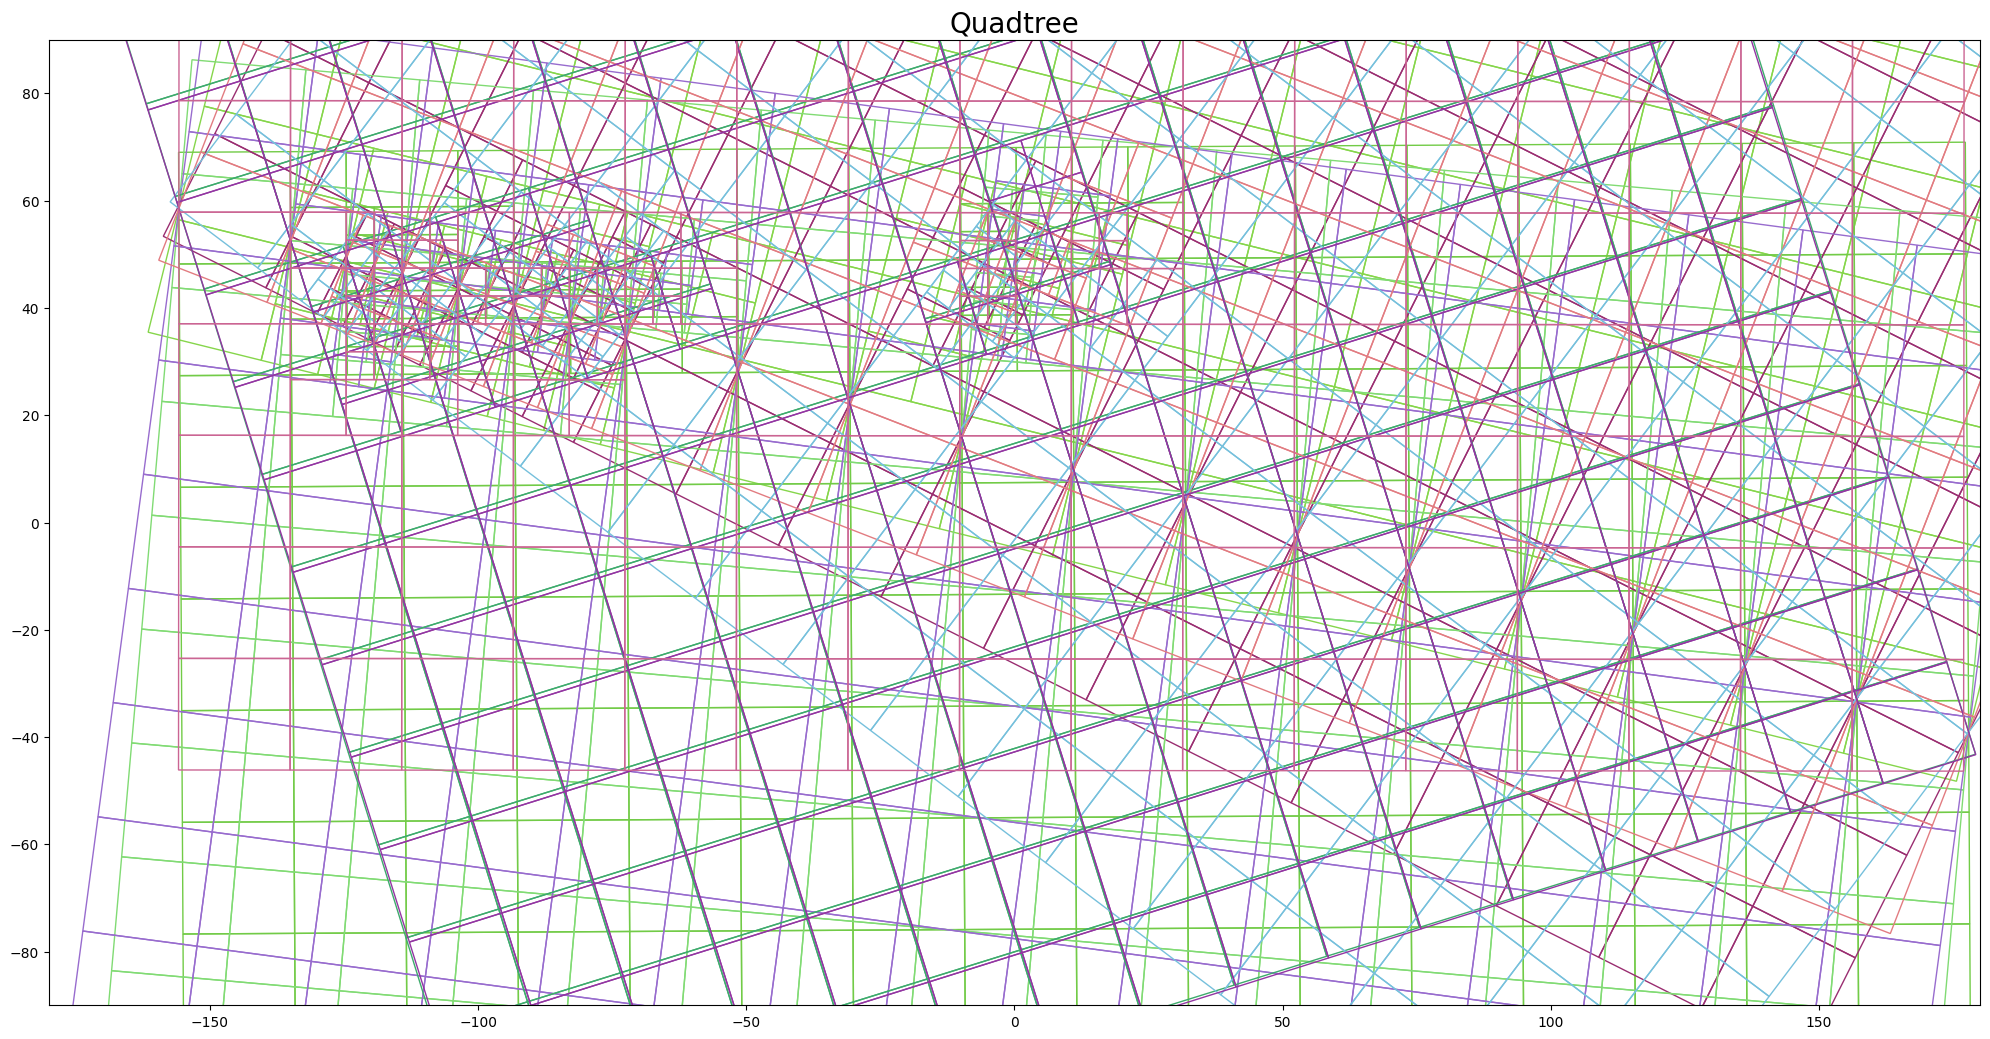

In [25]:
model.regressor.gridding_plot

In [47]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2023-09-12T15:18:11.839301+08:00

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 0.0.5
numpy       : 1.25.2
scipy       : 1.11.2
pandas      : 2.1.0
xgboost     : 2.0.0
tqdm        : 4.66.1
matplotlib  : 3.7.3
h3pandas    : 0.2.4
geopandas   : 0.13.2
scikit-learn: 1.3.0

